In [1]:
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from matplotlib import dates as mpl_dates
plt.style.use('seaborn')
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [2]:
df =pd.read_csv('household_power_consumption.txt', sep=";")
display(df.head())

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [3]:
# concatenate the data and time column
df_copy = df.copy()
df_copy['Datetime'] = df_copy['Date'].str.cat(df_copy['Time'], sep=' ')
# After concatenation, drop the date and time columns
df_copy.drop(['Date','Time'], inplace=True, axis=1)
df_copy.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime
0,4.216,0.418,234.840,18.400,0.000,1.000,17.0,16/12/2006 17:24:00
1,5.360,0.436,233.630,23.000,0.000,1.000,16.0,16/12/2006 17:25:00
2,5.374,0.498,233.290,23.000,0.000,2.000,17.0,16/12/2006 17:26:00
3,5.388,0.502,233.740,23.000,0.000,1.000,17.0,16/12/2006 17:27:00
4,3.666,0.528,235.680,15.800,0.000,1.000,17.0,16/12/2006 17:28:00


In [4]:
# check the data type and also if they are not null
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
Global_active_power      object
Global_reactive_power    object
Voltage                  object
Global_intensity         object
Sub_metering_1           object
Sub_metering_2           object
Sub_metering_3           float64
Datetime                 object
dtypes: float64(1), object(7)
memory usage: 126.7+ MB


In [5]:
# On conversion we discovered there are some characters'?' in the dataframe
# Replace '?' with nan
df_copy.replace('?', 'NAN', inplace=True)
print(df_copy.head())

  Global_active_power Global_reactive_power  Voltage Global_intensity  \
0               4.216                 0.418  234.840           18.400   
1               5.360                 0.436  233.630           23.000   
2               5.374                 0.498  233.290           23.000   
3               5.388                 0.502  233.740           23.000   
4               3.666                 0.528  235.680           15.800   

  Sub_metering_1 Sub_metering_2  Sub_metering_3             Datetime  
0          0.000          1.000            17.0  16/12/2006 17:24:00  
1          0.000          1.000            16.0  16/12/2006 17:25:00  
2          0.000          2.000            17.0  16/12/2006 17:26:00  
3          0.000          1.000            17.0  16/12/2006 17:27:00  
4          0.000          1.000            17.0  16/12/2006 17:28:00  


In [6]:
# Check to confirm that there are no duplicate date
df_copy.Datetime.describe()

count                2075259
unique               2075259
top       14/3/2009 16:58:00
freq                       1
Name: Datetime, dtype: object

In [7]:
# Convert the date time column to Datetime format and set the index as datetime
df_copy['Datetime'] = pd.to_datetime(df_copy['Datetime'], infer_datetime_format=True)
df_copy = df_copy.set_index(['Datetime'])
display(df_copy.head())

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [8]:
dataset = df_copy.astype('float')

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtypes: float64(7)
memory usage: 126.7 MB


In [10]:
# Check for the total number of null values in each column
dataset.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

**Check for the percenatge of missing data in each column**

In [11]:
def missing_data(dataset):
    # Calculate the percentage of missing data in each column
    Total = dataset.isnull().sum().sort_values(ascending = False)
    Percentage = (dataset.isnull().sum()/dataset.isnull().count() * 100).sort_values(ascending = False)
    missing_data = pd.concat([Total, Percentage], axis = 1, keys = ['Total', 'Percentage'])
    return missing_data

In [12]:
missing_data(dataset)

,Total,Percentage
Sub_metering_3,25979,1.251844
Sub_metering_2,25979,1.251844
Sub_metering_1,25979,1.251844
Global_intensity,25979,1.251844
Voltage,25979,1.251844
Global_reactive_power,25979,1.251844
Global_active_power,25979,1.251844


In [13]:
#  fill all the missing values with the mean (average) of their attribute/column. - This is certainly not a good practice as it causes overfitting
#dataset = dataset.ffill(axis=0)

#dataset[['Global_active_power','Global_reactive_power','Voltage','Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']] = dataset[['Global_active_power','Global_reactive_power','Voltage','Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']].fillna(value=dataset[['Global_active_power','Global_reactive_power','Voltage','Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']].mean())

# use the interpolation method for missing values to ensure that the input is reliable.
dataset = dataset.interpolate()

In [14]:
dataset.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [15]:
dataset.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [16]:
# check the total number of roles and columns
dataset.shape

(2075259, 7)

In [17]:
dataset_copy = dataset.copy()
dataset_copy.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [18]:
round(dataset_copy.describe(include='all'), 2)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2075259.00,2075259.00,2075259.00,2075259.00,2075259.00,2075259.00,2075259.00
mean,1.09,0.12,240.83,4.62,1.11,1.29,6.44
std,1.05,0.11,3.24,4.42,6.12,5.79,8.42
min,0.08,0.00,223.20,0.20,0.00,0.00,0.00
25%,0.31,0.05,238.99,1.40,0.00,0.00,0.00
50%,0.61,0.10,241.00,2.75,0.00,0.00,1.00
75%,1.53,0.19,242.87,6.40,0.00,1.00,17.00
max,11.12,1.39,254.15,48.40,88.00,80.00,31.00


**Resampling The Dataset**

In [19]:
# Before we can start performing analysis, we have to resample the datetime into daily date
data_hourly = dataset_copy.resample('H').mean()
#print('Daily Energy Data Table')
#display(data_daily.head())

data_daily = dataset_copy.resample('D').mean()
#print('Daily Energy Data Table')
#display(data_daily.head())

data_weekly = dataset_copy.resample('W').mean()
#print('Weekly Energy Data Table')
#display(data_weekly.head())

data_monthly = dataset_copy.resample('M').mean()
#print('Monthly Energy Data table')
#display(data_monthly.head())

data_Quarterly = dataset_copy.resample('Q').mean()
#print('Quarterly Energy Data Table')
#display(data_Quarterly.head())

data_yearly = dataset_copy.resample('Y').mean()
#print('Yearly Energy Data Table')
#display(data_Yearly.head())

**Exploratory Data Analysis**

In [20]:
# Let's make a copy of the working dataset 
data = dataset_copy.copy()
data.reset_index(inplace=True)

In [21]:
#data = data.groupby(data['Datetime'].dt.strftime('%B')).mean()

# Split the datetime column into the different columns below
data['Day'] = data['Datetime'].dt.day
data['Time'] = data['Datetime'].dt.time
data['Month'] = data['Datetime'].dt.month
data['Year'] = data['Datetime'].dt.year

In [22]:
submeter_df = data[['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']]
submeter_breakdown_df = pd.melt(submeter_df, id_vars=None, var_name = 'Sub_meter', value_name='Energy Consumption')
submeter_breakdown_df = submeter_breakdown_df.groupby('Sub_meter').sum()
submeter_breakdown_df.head()
#submeter_df.sample(20)

,Energy Consumption
Sub_meter,
Sub_metering_1,2302468.5
Sub_metering_2,2675484.5
Sub_metering_3,13369618.5


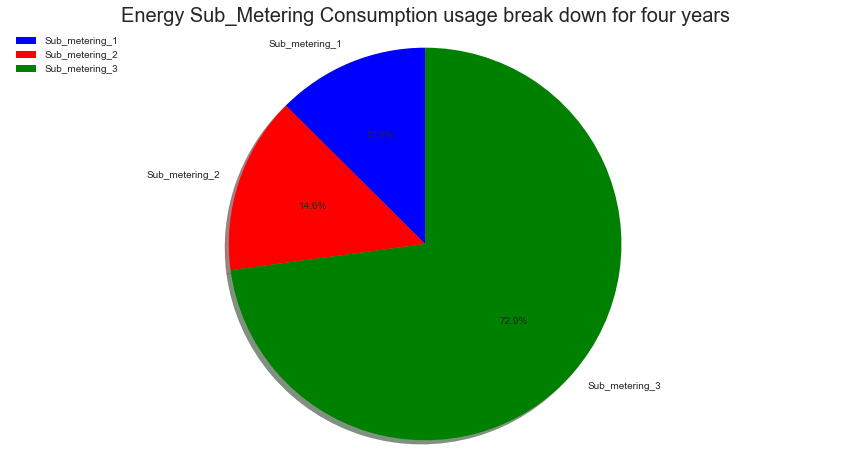

In [23]:
plt.figure(figsize=(15,8))
my_labels = 'Sub_metering_1','Sub_metering_2','Sub_metering_3'
my_colors = ['blue','red','green']
#my_explode = (0, 0.1, 0)
plt.pie(submeter_breakdown_df, labels=my_labels, autopct='%1.1f%%', startangle=90, shadow = True, colors=my_colors)
plt.title('Energy Sub_Metering Consumption usage break down for four years', size=20)
plt.axis('equal')
plt.legend(loc='upper left')
plt.show()

The pie chart above, shows the appliances connected to sub_meter_3 consumed a 72% of energy produced within the period specified.

**Check for the Pearson's Correlation Test**

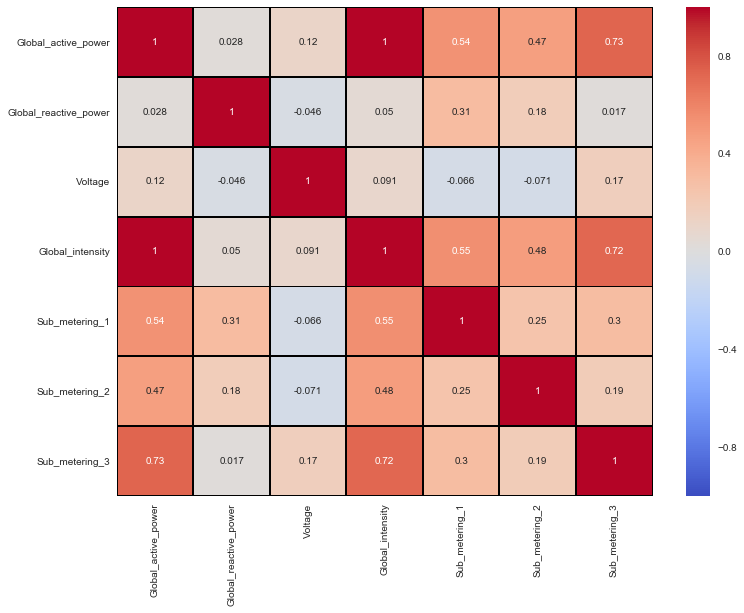

In [24]:
# Plot the correlation heat map
plt.figure(figsize=(12,9))
sns.heatmap(data_daily.corr(), annot = True, fmt='0.2g', vmin=-1, vmax=1, center=0, cmap= 'coolwarm', linewidths=1, linecolor='black')

From the correlation graph, we can see that Global Intensity is highly correlated, while Sub_metering 1,2 and 3 are also positively correlated with the target variable Global Active Power feature.

**Average Energy Consumption Per Year (YEARLY TREND)**

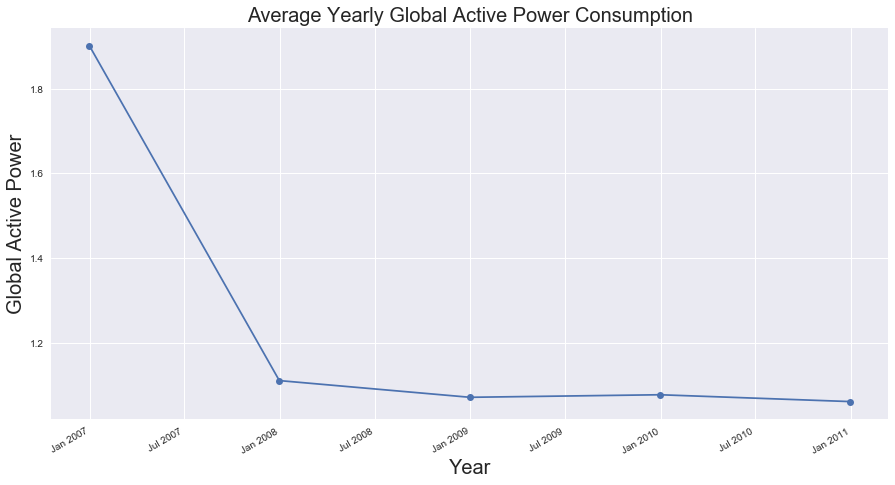

In [25]:
# Plot the yearly data point to ascertain the yearly trend
plt.figure(figsize=(15,8))
plt.plot(data_yearly.index, data_yearly.Global_active_power, marker='o')
plt.xlabel('Year', size=20)
plt.ylabel('Global Active Power', size=20)
plt.title('Average Yearly Global Active Power Consumption', size=20)
plt.grid(True)
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%b %Y')
plt.gca().xaxis.set_major_formatter(date_format)

From the graph above, we see that there was a constant decrease in the consumption of energy from 2007 to 2008, after which it stablished abit and from 2010, there was a slight decrease to 2011.

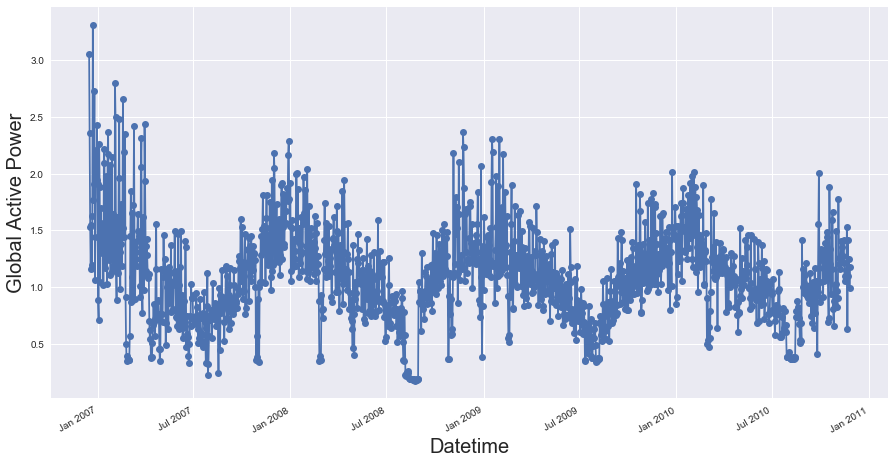

In [26]:
#
plt.figure(figsize=(15,8))
plt.plot(data_daily.index, data_daily.Global_active_power, marker='o', )
plt.xlabel('Datetime', size='20')
plt.ylabel('Global Active Power', size='20')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%b %Y')
plt.gca().xaxis.set_major_formatter(date_format)

From the graph above, the time series data oscillate between high and low values on a yearly time scale, indicating some form of seasonality in the data.

**Average Energy Consumption in a Month**

In [27]:
# using the group by function group the data using the month column
df_month = data.groupby('Month').mean()
#df_month

In [28]:
# Plot the yearly data point to ascertain the yearly trend
#plt.figure(figsize=(15,8))
#plt.plot(df_month.index, df_month.Global_active_power, marker='o')
#plt.xlabel('Months', size=20)
#plt.ylabel('Global Active Power', size=20)
#plt.title('Average Monthly Global Active Power Consumption', size=20)
#plt.grid(True)
#plt.show()

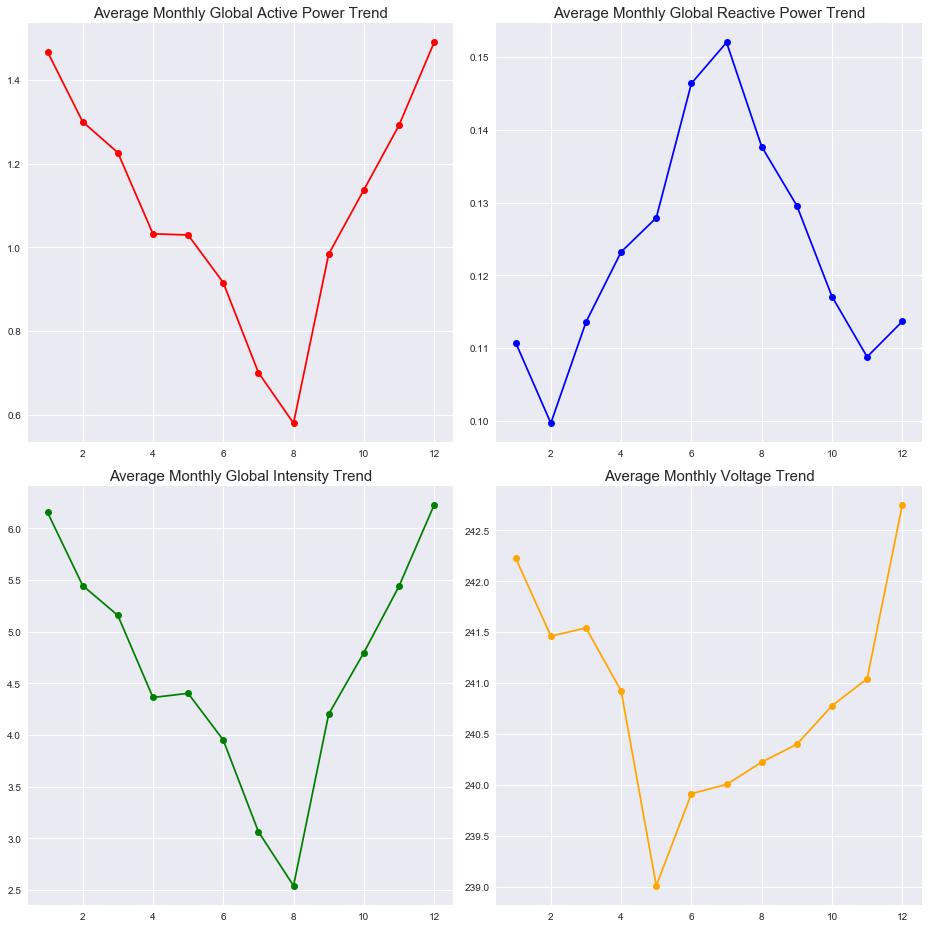

In [29]:
# Create a figure and sub-plots of 2 rows by 2 columns. Retrieve the handles of figure and subplot axes

fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13,13))

# Choose the axes for plotting
ax1.plot(df_month.index, df_month.Global_active_power, color='red', marker='o')
ax1.set_title('Average Monthly Global Active Power Trend', size=15)

ax2.plot(df_month.index, df_month.Global_reactive_power, color='blue', marker='o')
ax2.set_title('Average Monthly Global Reactive Power Trend', size=15)

ax3.plot(df_month.index, df_month.Global_intensity, color='green', marker='o')
ax3.set_title('Average Monthly Global Intensity Trend', size=15)

ax4.plot(df_month.index, df_month.Voltage, color='orange', marker='o')
ax4.set_title('Average Monthly Voltage Trend', size=15)

plt.tight_layout()  # Prevent subplots overlap
plt.show()

Each of the series have a fairly similar trend patterns through the *months* except for Average Monthly Global Reactive Power, where a different pattern is noticed.

**Average Energy Consumption in each Day in a month**

In [30]:
# using the groupby function to group the data using the DAY column
df_day = data.groupby('Day').mean()
#df_day

In [31]:
# Plot the yearly data point to ascertain the yearly trend
#plt.figure(figsize=(15,8))
#plt.plot(df_day.index, df_day.Global_active_power, marker='o')
#plt.xlabel('Daily', size=20)
#plt.ylabel('Global Active Power', size=20)
#plt.title('Average Daily Global Active Power Consumption', size=20)
#plt.grid(True)
#plt.show()

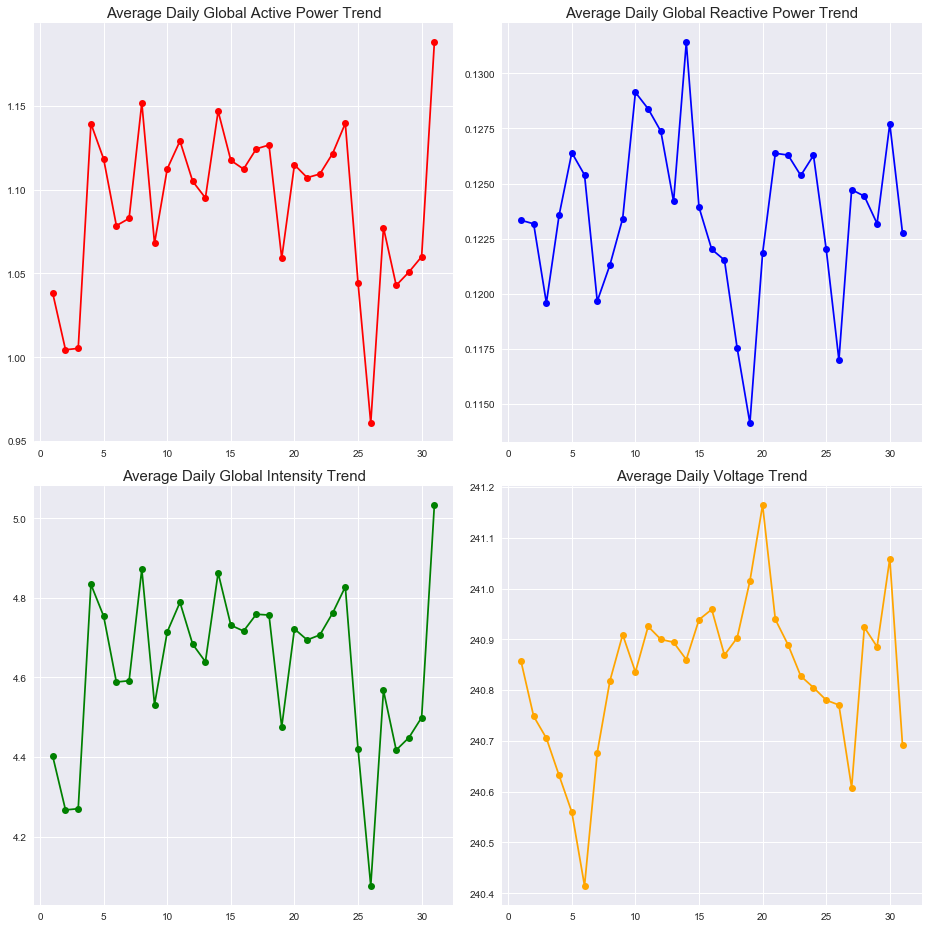

In [32]:
# Create a figure and sub-plots of 2 rows by 2 columns. Retrieve the handles of figure and subplot axes

fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13,13))

# Choose the axes for plotting
ax1.plot(df_day.index, df_day.Global_active_power, color='red', marker='o')
ax1.set_title('Average Daily Global Active Power Trend', size=15)

ax2.plot(df_day.index, df_day.Global_reactive_power, color='blue', marker='o')
ax2.set_title('Average Daily Global Reactive Power Trend', size=15)

ax3.plot(df_day.index, df_day.Global_intensity, color='green', marker='o')
ax3.set_title('Average Daily Global Intensity Trend', size=15)

ax4.plot(df_day.index, df_day.Voltage, color='orange', marker='o')
ax4.set_title('Average Daily Voltage Trend', size=15)

plt.tight_layout()  # Prevent subplots overlap
plt.show()

**Average Energy Consumption Per Hourly**

In [33]:
# To be able to use the time column by grouping into hourly, we call the resampled hourly variable
# maake the time column the index
data_hourly.index = data_hourly.index.time
# perform grouping using the index
df_hourly = data_hourly.groupby(data_hourly.index).mean()
df_hourly.reset_index(inplace=True)
#df_hourly

In [34]:
# Plot the yearly data point to ascertain the yearly trend
#plt.figure(figsize=(15,8))
#plt.plot(df_hourly.index, df_hourly.Global_active_power, marker='o')
#plt.xlabel('Hourly', size=20)
#plt.ylabel('Global Active Power', size=20)
#plt.title('Average Hourly Global Active Power Consumption', size=20)
#plt.grid(True)
#plt.show()

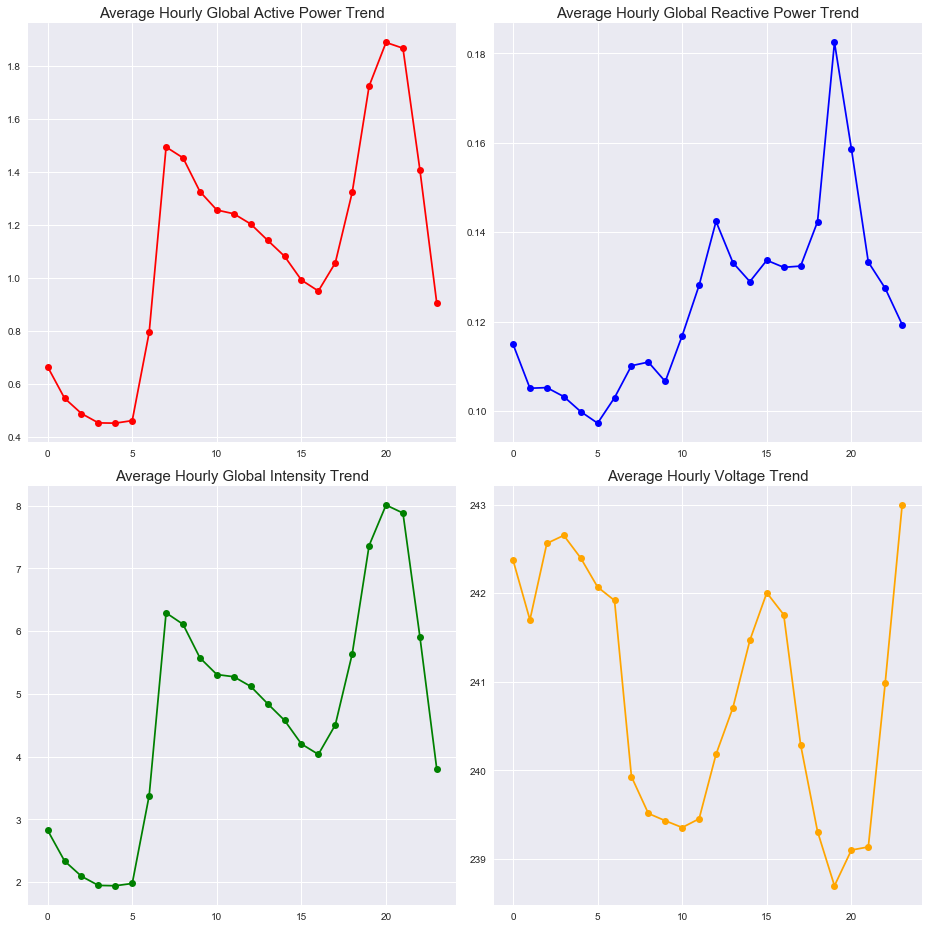

<Figure size 432x288 with 0 Axes>

In [35]:
# Create a figure and sub-plots of 2 rows by 2 columns. Retrieve the handles of figure and subplot axes

fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13,13))

# Choose the axes for plotting
ax1.plot(df_hourly.index, df_hourly.Global_active_power, color='red', marker='o')
ax1.set_title('Average Hourly Global Active Power Trend', size=15)

ax2.plot(df_hourly.index, df_hourly.Global_reactive_power, color='blue', marker='o')
ax2.set_title('Average Hourly Global Reactive Power Trend', size=15)

ax3.plot(df_hourly.index, df_hourly.Global_intensity, color='green', marker='o')
ax3.set_title('Average Hourly Global Intensity Trend', size=15)

ax4.plot(df_hourly.index, df_hourly.Voltage, color='orange', marker='o')
ax4.set_title('Average Hourly Voltage Trend', size=15)

plt.tight_layout()  # Prevent subplots overlap
plt.show()
plt.savefig("Average Energy Consumption per hour.jpg")

**Feature Engineering**

Text(0.5, 1.0, 'Global Active Power Data Distribution')

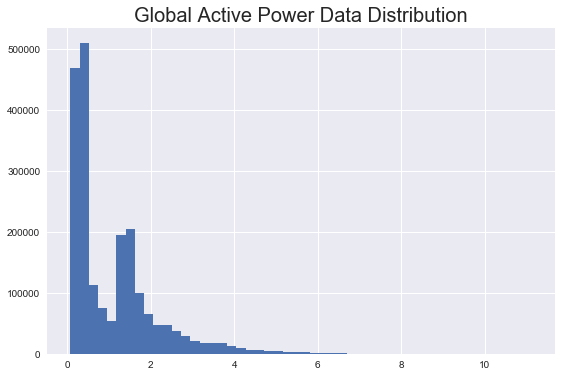

In [36]:
# Checking the data distribution
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
dataset_copy['Global_active_power'].hist(bins=50)
plt.title('Global Active Power Data Distribution', size=20)

From the histogram above, we can immediately see that Global Active Power data points is not normally distibuted.

**We will be using the VAR Model, and as such we have to carry out some test to ensure our model can be used.**

**Testing Causation using Granger’s Causality Test**

In [37]:
from statsmodels.tsa.stattools import grangercausalitytests


def grangers_causation_matrix(data, variables, test='ssr_chi2test', maxlag=6):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [38]:
grangers_causation_matrix(dataset, variables = dataset.columns) 

,Global_active_power_x,Global_reactive_power_x,Voltage_x,Global_intensity_x,Sub_metering_1_x,Sub_metering_2_x,Sub_metering_3_x
Global_active_power_y,1.0,0.0,0.0,0.0000,0.0,0.0,0.0
Global_reactive_power_y,0.0,1.0,0.0,0.0000,0.0,0.0,0.0
Voltage_y,0.0,0.0,1.0,0.0000,0.0,0.0,0.0
Global_intensity_y,0.0,0.0,0.0,0.9999,0.0,0.0,0.0
Sub_metering_1_y,0.0,0.0,0.0,0.0000,1.0,0.0,0.0
Sub_metering_2_y,0.0,0.0,0.0,0.0000,0.0,1.0,0.0
Sub_metering_3_y,0.0,0.0,0.0,0.0000,0.0,0.0,1.0


Explaining the above table, If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row). So, you can reject the null hypothesis and conclude Column_x causes Row_y.

Looking at the P-Values in the above table, you can pretty much observe that almost all the variables (time series) in the system are interchangeably causing each other.

This makes this system of multi time series a good candidate for using VAR models to forecast.

**Cointegration Test**

In [39]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)


In [40]:
cointegration_test(dataset)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Global_active_power ::  307422.05 > 111.7797  =>   True
Global_reactive_power ::  218300.65 > 83.9383   =>   True
Voltage ::  137589.74 > 60.0627   =>   True
Global_intensity ::  77849.89  > 40.1749   =>   True
Sub_metering_1 ::  33787.6   > 24.2761   =>   True
Sub_metering_2 ::  12806.35  > 12.3212   =>   True
Sub_metering_3 ::  1.33      > 4.1296    =>   False


From the test result above, we can immediately establish the presence of a statistically significant connection between two or more time series. Hence the collection of series is said to be cointegrated.

**MODELLING**

**Split the Series into Training and Testing Data**

In [41]:
# number of observations 
nobs = 2000000

# split df into test and train dataset
df_train, df_test = dataset[0:-nobs], dataset[-nobs:]

# Check size
print(df_train.shape)
print(df_test.shape) 

(75259, 7)
(2000000, 7)


**Let's Perform the Stationarity Test since this very enssential in performing 
time series forecasting. We will be using the Augmented Dickey-Fuller Test (ADF Test)**

In [42]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

In [43]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Global_active_power" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -14.3224
 No. Lags Chosen       = 61
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Global_reactive_power" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -23.2847
 No. Lags Chosen       = 63
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Voltage" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stati

Let's check the different graph to confirm seasonality.

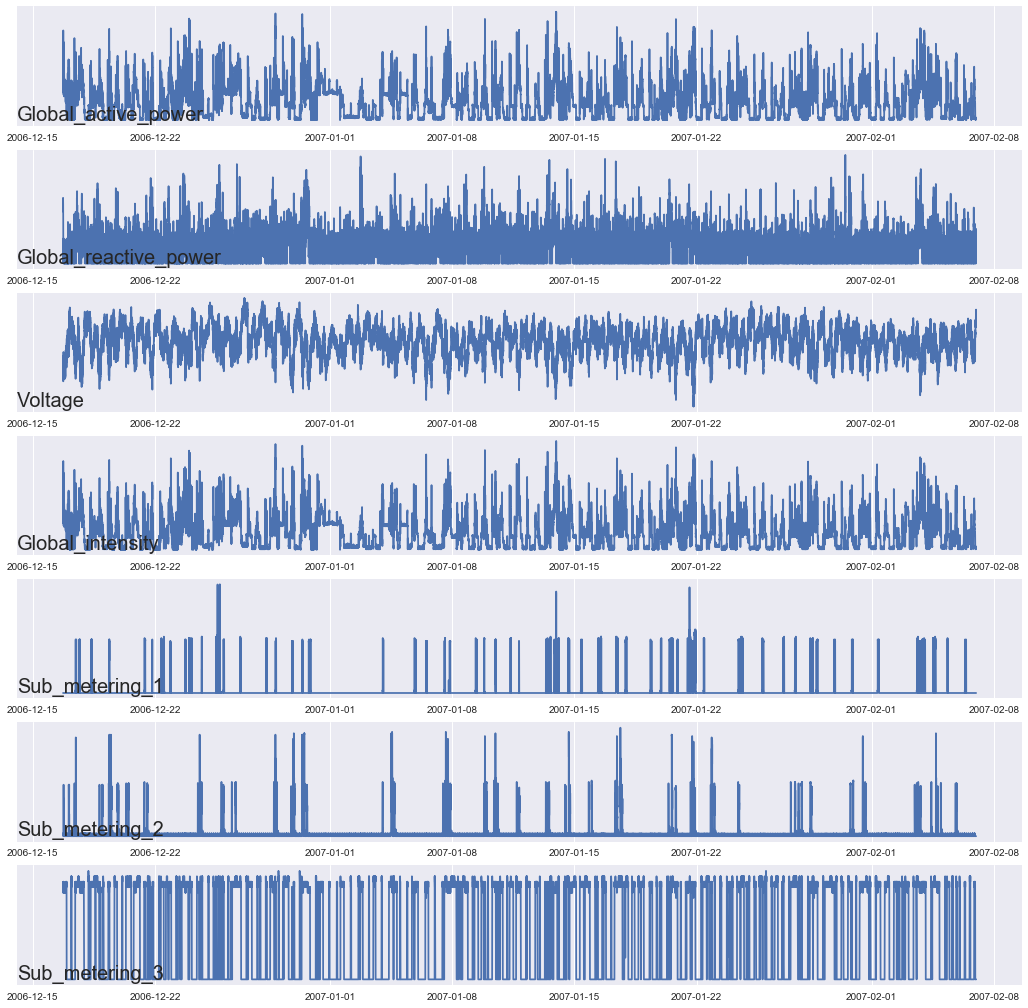

In [45]:
# Using a line plot, lets check the trends and pattern in each of the features
fig, ax = plt.subplots(figsize=(18, 18))

for i in range(len(df_train.columns)):
    # prepare subplot for each column 
    plt.subplot(len(df_train.columns), 1, i+1)
    
    # determine the name of the column
    name = df_train.columns[i]
    
    # plot each feature/column
    plt.plot(df_train[name])
    
    # title each plot
    plt.title(name, y=0, size=20, loc='left')
    plt.yticks([])
    plt.grid(True)
plt.show()

Some form of seasonality is still observed.

In [46]:
df_differenced = df_train.diff().dropna()

In [47]:
# ADF Test on each column of Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Global_active_power" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -47.818
 No. Lags Chosen       = 59
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Global_reactive_power" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -50.4013
 No. Lags Chosen       = 63
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Voltage" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Statio

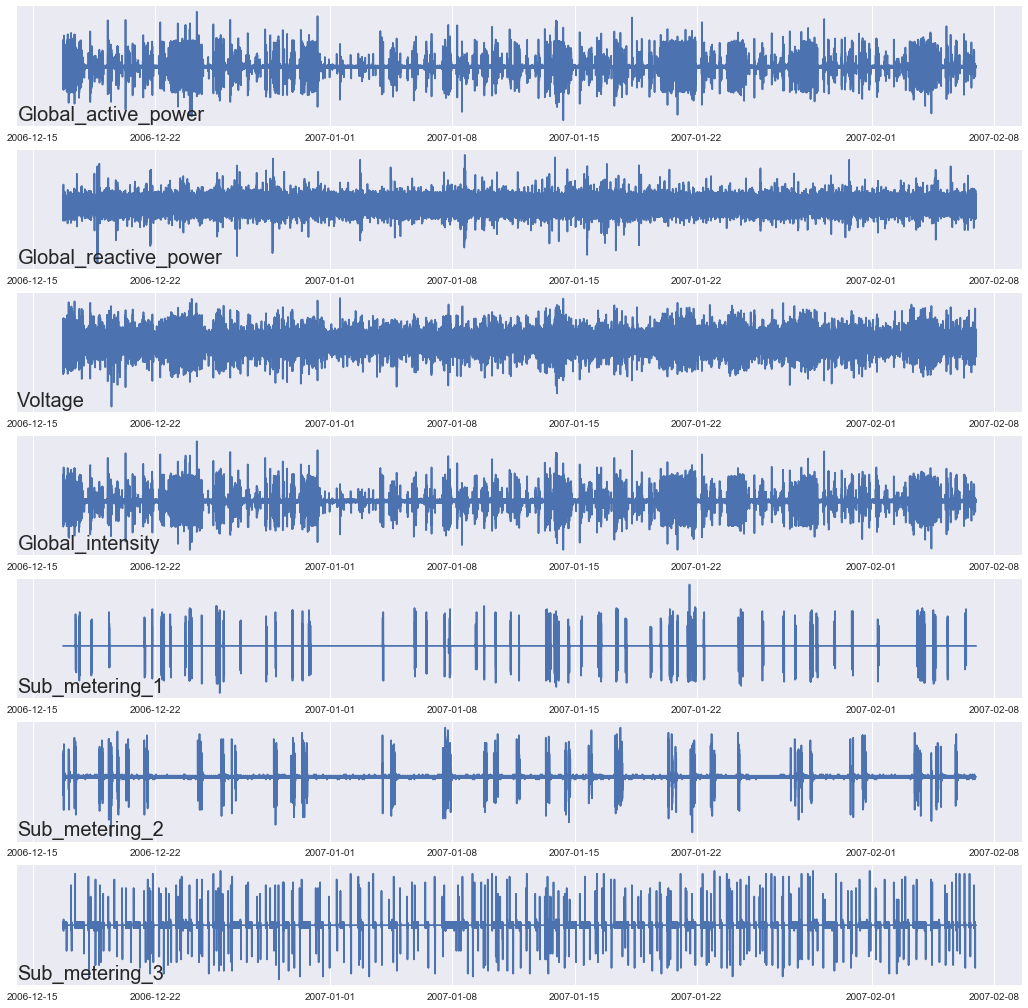

In [49]:
# Using a line plot, lets check the trends and pattern in each of the features
fig, ax = plt.subplots(figsize=(18, 18))

for i in range(len(df_differenced.columns)):
    # prepare subplot for each column 
    plt.subplot(len(df_differenced.columns), 1, i+1)
    
    # determine the name of the column
    name = df_differenced.columns[i]
    
    # plot each feature/column
    plt.plot(df_differenced[name])
    
    # title each plot
    plt.title(name, y=0, size=20, loc='left')
    plt.yticks([])
    plt.grid(True)
plt.show()

**Let's select the Order (P) of VAR model by picking the order that gives the model with least AIC**

In [79]:
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(df_train)
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,6.802,6.803,899.4,6.802
1,-8.483,-8.476,0.0002070,-8.481
2,-8.760,-8.748,0.0001568,-8.756
3,-8.952,-8.933,0.0001294,-8.947
4,-9.025,-9.000,0.0001203,-9.018
5,-9.150,-9.119,0.0001062,-9.141
6,-9.200,-9.163,0.0001011,-9.188
7,-9.227,-9.184,9.836e-05,-9.214
8,-9.261,-9.212,9.508e-05,-9.246
9,-9.283,-9.228*,9.303e-05,-9.266


The selected order(p) is the order that gives the lowest ‘AIC’, ‘BIC’, ‘FPE’ and ‘HQIC’ scores. which is 12

**Train Model**

In [80]:
model_fitted = model.fit(12)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 17, Nov, 2020
Time:                     14:17:02
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -9.22055
Nobs:                     75247.0    HQIC:                  -9.27109
Log likelihood:          -397146.    FPE:                9.20185e-05
AIC:                     -9.29352    Det(Omega_mle):     9.12942e-05
--------------------------------------------------------------------
Results for equation Global_active_power
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                             0.658241         0.137210            4.797           0.000
L1.Global_active_power           -0.357698         0.026923          -13.286           0.00

**Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic**

The value of this statistic can vary between 0 and 4. The closer it is to the value 2, then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.

In [82]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(dataset.columns, out):
    print(col, ':', round(val, 2))

Global_active_power : 2.0
Global_reactive_power : 2.0
Voltage : 2.0
Global_intensity : 2.0
Sub_metering_1 : 2.0
Sub_metering_2 : 2.0
Sub_metering_3 : 2.0


There's no serial correlation which means there is no leftover pattern in the residuals. Let’s proceed with the forecast.

In [83]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)

# Input data for forecasting
forecast_input = df_train.values[-lag_order:]
forecast_input

12


array([[3.4800e-01, 1.5200e-01, 2.4655e+02, 1.6000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00],
       [3.4600e-01, 1.5800e-01, 2.4758e+02, 1.6000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00],
       [3.4200e-01, 1.5000e-01, 2.4630e+02, 1.6000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00],
       [3.9400e-01, 2.0600e-01, 2.4742e+02, 1.8000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00],
       [4.1800e-01, 2.6600e-01, 2.4733e+02, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00],
       [4.1800e-01, 2.7000e-01, 2.4770e+02, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00],
       [4.2000e-01, 2.7800e-01, 2.4884e+02, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00],
       [4.1400e-01, 2.7000e-01, 2.4785e+02, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00],
       [4.1400e-01, 2.7400e-01, 2.4851e+02, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00],
       [4.0600e-01, 2.6600e-01, 2.4751e+02, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0

#### Let's make our forecast

In [91]:
# Make the prediction
forecast = model_fitted.forecast(y=forecast_input, steps=nobs)

# create a dataframe
df_forecast = pd.DataFrame(forecast, index=dataset.index[-nobs:], columns=dataset.columns + '_forecast')
df_forecast.head()

,Global_active_power_forecast,Global_reactive_power_forecast,Voltage_forecast,Global_intensity_forecast,Sub_metering_1_forecast,Sub_metering_2_forecast,Sub_metering_3_forecast
Datetime,,,,,,,
2007-02-06 23:43:00,0.462464,0.253518,247.470126,2.146558,0.148837,0.171564,0.043882
2007-02-06 23:44:00,0.450079,0.238020,247.409921,2.100585,0.284263,0.066589,0.072813
2007-02-06 23:45:00,0.428835,0.226659,247.447477,2.011772,0.363367,0.186668,0.143533
2007-02-06 23:46:00,0.417328,0.212395,247.416421,1.951765,0.432870,0.182939,0.192461
2007-02-06 23:47:00,0.401340,0.198496,247.434324,1.877834,0.489415,0.239670,0.280912


#### Invert the transformation. 
Since we applied differencing before training the data, we need to transform the data back to its original values.

In [92]:
# Roll back from the 1st order differencing
# we take the cumulative sum (from the top row to the bottom) 
# for each of the forecasting data, and the add to the previous step’s 
# original value (since we deduct each row from the previous one)
# we rename the new forecasted column with the prefix ‘_forecast’

def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_forecast = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_forecast[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_forecast[str(col)+'_forecast'].cumsum()
        # Roll back 1st Diff
        df_forecast[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_forecast[str(col)+'_forecast'].cumsum()
    return df_forecast

In [93]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results = df_results.loc[:, ['Global_active_power_forecast', 'Global_reactive_power_forecast', 'Voltage_forecast', 
                   'Global_intensity_forecast', 'Sub_metering_1_forecast', 'Sub_metering_2_forecast', 'Sub_metering_3_forecast']]
df_results.head()

,Global_active_power_forecast,Global_reactive_power_forecast,Voltage_forecast,Global_intensity_forecast,Sub_metering_1_forecast,Sub_metering_2_forecast,Sub_metering_3_forecast
Datetime,,,,,,,
2007-02-06 23:43:00,0.862464,0.519518,495.070126,4.146558,0.148837,0.171564,0.043882
2007-02-06 23:44:00,1.312543,0.757538,742.480047,6.247143,0.433100,0.238153,0.116694
2007-02-06 23:45:00,1.741378,0.984198,989.927524,8.258915,0.796466,0.424821,0.260227
2007-02-06 23:46:00,2.158705,1.196593,1237.343945,10.210680,1.229336,0.607760,0.452687
2007-02-06 23:47:00,2.560046,1.395088,1484.778269,12.088514,1.718751,0.847430,0.733600


#### Plot of Forecast vs Actuals

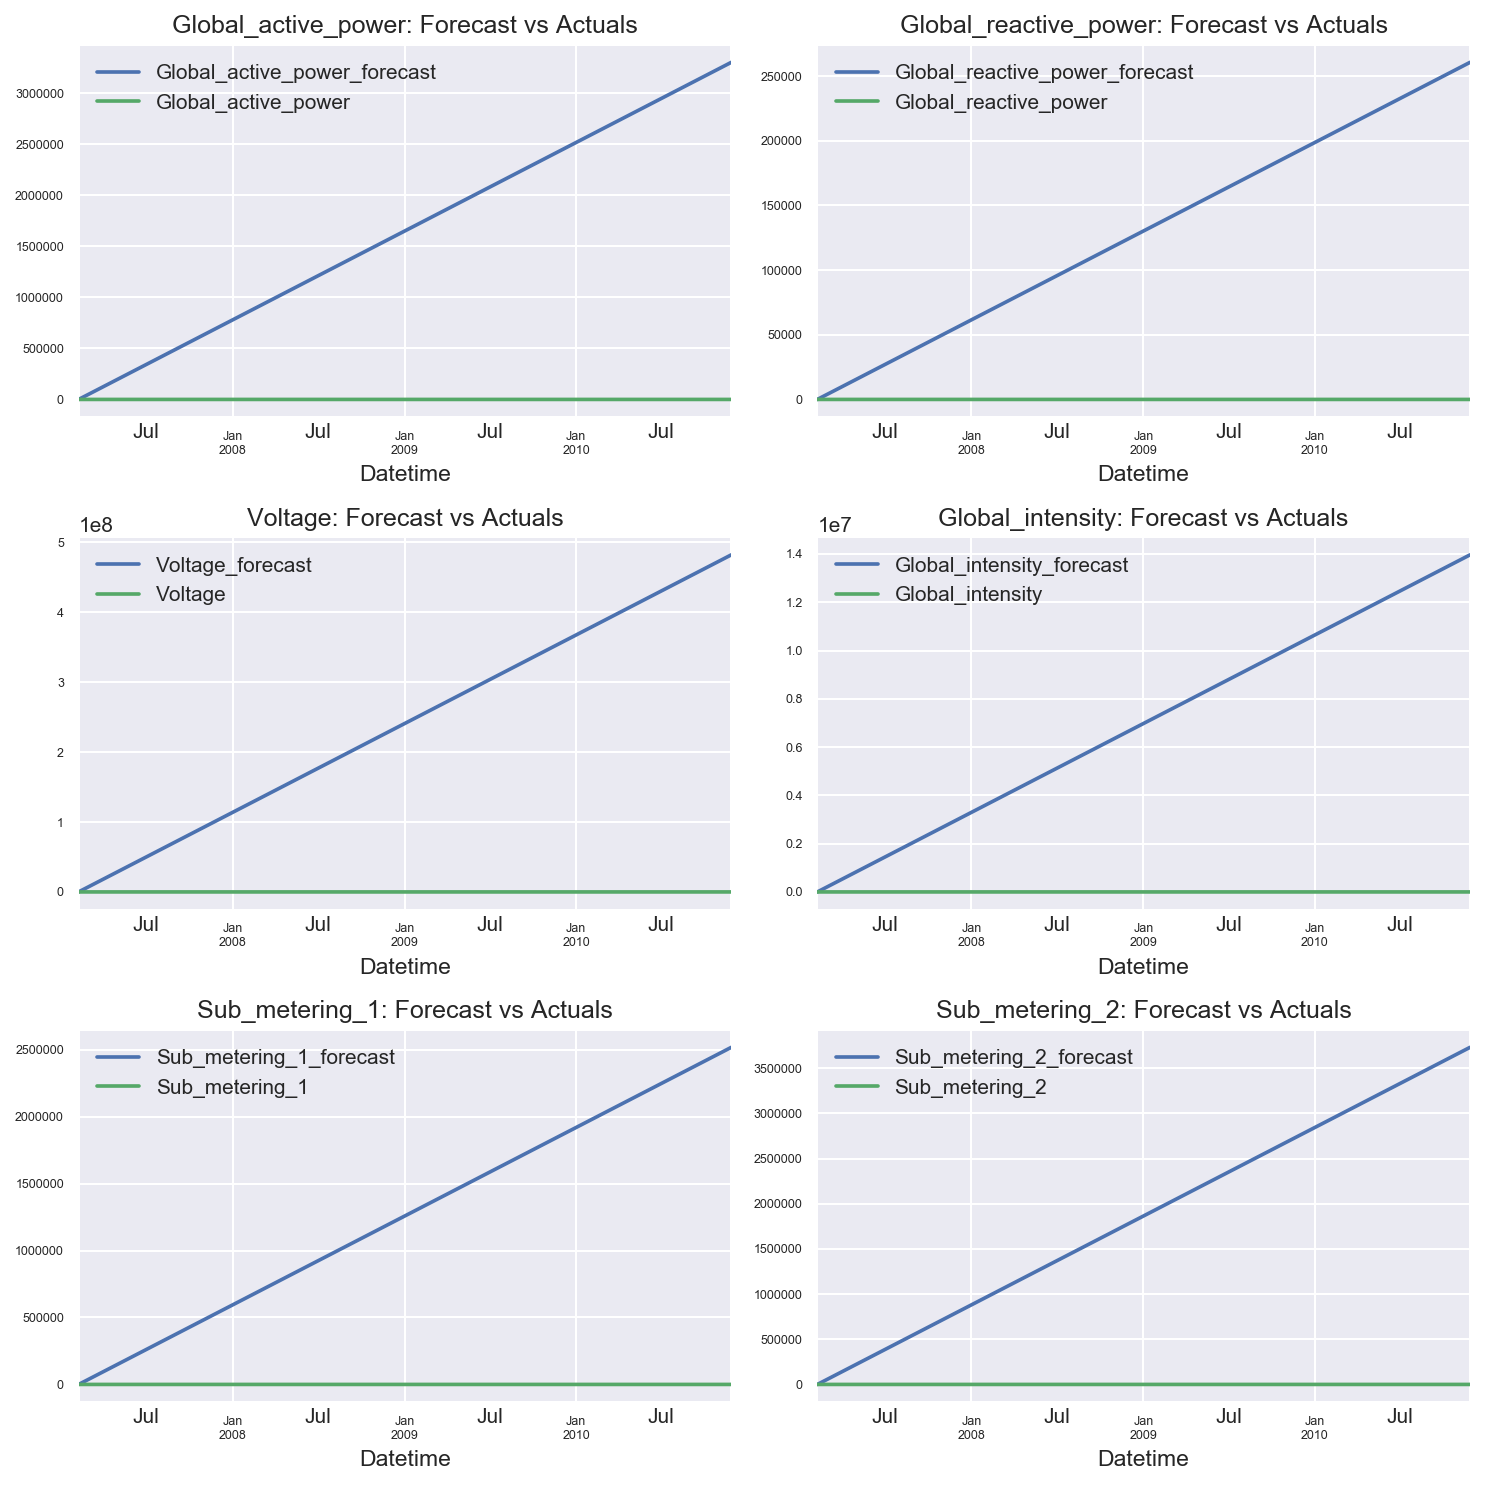

In [97]:
fig, axes = plt.subplots(nrows=int(len(dataset.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(dataset.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [95]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: Global_active_power')
accuracy_prod = forecast_accuracy(df_results['Global_active_power_forecast'].values, df_test['Global_active_power'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: Global_reactive_power')
accuracy_prod = forecast_accuracy(df_results['Global_reactive_power_forecast'].values, df_test['Global_reactive_power'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: Voltage')
accuracy_prod = forecast_accuracy(df_results['Voltage_forecast'].values, df_test['Voltage'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: Global_intensity')
accuracy_prod = forecast_accuracy(df_results['Global_intensity_forecast'].values, df_test['Global_intensity'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: Sub_metering_1')
accuracy_prod = forecast_accuracy(df_results['Sub_metering_1_forecast'].values, df_test['Sub_metering_1'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: Sub_metering_2')
accuracy_prod = forecast_accuracy(df_results['Sub_metering_2_forecast'].values, df_test['Sub_metering_2'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: Sub_metering_3')
accuracy_prod = forecast_accuracy(df_results['Sub_metering_3_forecast'].values, df_test['Sub_metering_3'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

Forecast Accuracy of: Global_active_power
mape :  3422406.9015
me :  1650634.8548
mae :  1650634.8548
mpe :  3422406.9015
rmse :  1906054.6077
corr :  -0.0065
minmax :  1.0

Forecast Accuracy of: Global_reactive_power
mape :  inf
me :  130320.3295
mae :  130320.3295
mpe :  inf
rmse :  150481.9376
corr :  0.0574
minmax :  1.0

Forecast Accuracy of: Voltage
mape :  998808.708
me :  241011645.0111
mae :  241011645.0111
mpe :  998808.708
rmse :  278295969.7621
corr :  0.2734
minmax :  1.0

Forecast Accuracy of: Global_intensity
mape :  3412912.5727
me :  6981762.5204
mae :  6981762.5204
mpe :  3412912.5727
rmse :  8062120.635
corr :  -0.011
minmax :  1.0

Forecast Accuracy of: Sub_metering_1
mape :  inf
me :  1258359.1362
mae :  1258359.1362
mpe :  inf
rmse :  1453102.2704
corr :  -0.0154
minmax :  1.0

Forecast Accuracy of: Sub_metering_2
mape :  inf
me :  1865186.0287
mae :  1865186.0287
mpe :  inf
rmse :  2153807.2239
corr :  -0.035
minmax :  1.0

Forecast Accuracy of: Sub_metering_3
ma